In [78]:
import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, NullLocator
from matplotlib.colors import Normalize

import seaborn as sns
sns.set(font_scale=1.2)

%matplotlib inline

In [2]:
def get_df(athlete_id: int):
    athlete_url = f'https://www.parkrun.ru/results/athleteeventresultshistory/?athleteNumber={athlete_id}&eventNumber=0'
    page_all_results = requests.get(athlete_url, headers={'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:86.0) Gecko/20100101 Firefox/86.0'})
    df = pd.read_html(page_all_results.text)[2]
    df['Год'] = pd.to_datetime(df['Дата parkrun'], dayfirst=True).dt.year
    df['Месяц'] = pd.to_datetime(df['Дата parkrun'], dayfirst=True).dt.month_name(locale='ru_RU.UTF-8').str.slice(stop=3)
    return df

In [5]:
# Personal parkrun ID
my_id = 875743

In [6]:
df = get_df(my_id)
df

,Паркран,Дата parkrun,Номер пробежки,Место,Время,Рейтинг,ЛР?,Год,Месяц
0,Natashinsky,24/07/2021,113,7,18:26,72.97%,NaN,2021,Июл
1,Tula Central,17/07/2021,202,3,19:30,68.97%,NaN,2021,Июл
2,Tula Central,26/06/2021,199,4,19:28,69.09%,NaN,2021,Июн
3,Natashinsky,19/06/2021,111,3,19:01,70.73%,NaN,2021,Июн
4,Kuzminki,29/05/2021,212,3,19:00,70.79%,NaN,2021,Мая
...,...,...,...,...,...,...,...,...,...
188,Gorky Park,25/10/2014,25,1,18:07,71.76%,NaN,2014,Окт
189,Kolomenskoe,22/03/2014,4,2,19:14,67.42%,NaN,2014,Мар
190,Kolomenskoe,15/03/2014,3,10,20:01,64.78%,NaN,2014,Мар
191,Kolomenskoe,08/03/2014,2,2,18:59,68.31%,NaN,2014,Мар


In [17]:
months = ['Янв','Фев','Мар','Апр','Мая','Июн','Июл','Авг','Сен','Окт','Ноя','Дек']

In [18]:
rundata_long = df.pivot_table(index='Месяц', columns='Год', values='Время', aggfunc=len, fill_value=0).astype(int)

for month in months:
    if month not in rundata_long.index.values:
        rundata_long.loc[month] = 0
# sort chronological
rundata_long = rundata_long.reindex(months)
maxruns = rundata_long.max().max()

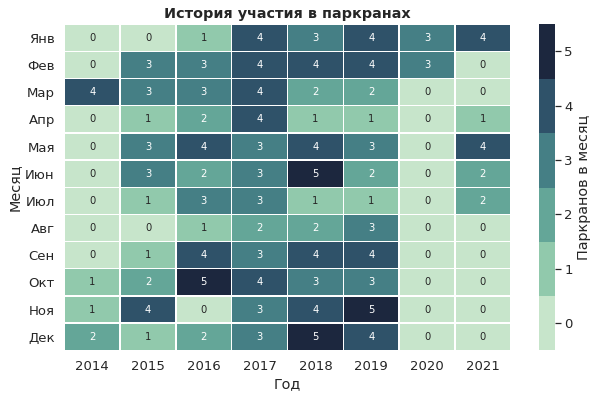

CPU times: user 1.81 s, sys: 1.61 s, total: 3.43 s
Wall time: 5.57 s


In [19]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))

# Plot number of runs by month/year
cmap = sns.cubehelix_palette(rot=-.4, n_colors=maxruns+1)

ticks=np.arange(0,maxruns+1)
boundaries = np.arange(-0.5,maxruns+1.5 )

ax = sns.heatmap(rundata_long, annot=True, linewidths=0.4, cmap=cmap,
                 cbar_kws={"ticks":ticks, "boundaries":boundaries, 'label': 'Паркранов в месяц'})
ax.set_title("История участия в паркранах", fontweight='bold')

plt.show()

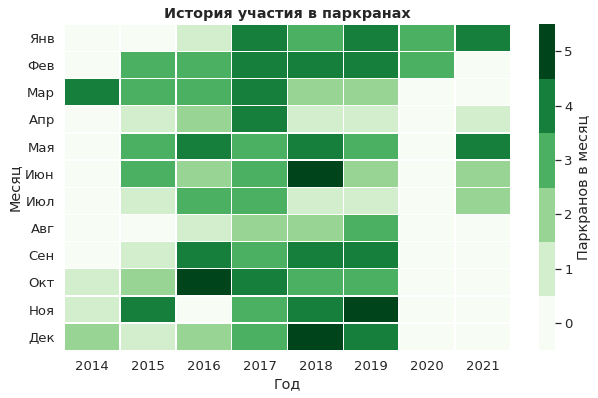

CPU times: user 535 ms, sys: 204 ms, total: 740 ms
Wall time: 1.01 s


In [20]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))

ticks=np.arange(0, maxruns+1)
boundaries = np.arange(-0.5, maxruns+1.5)

sns.heatmap(rundata_long, linewidths=0.4, cmap='Greens',
            cbar_kws={"ticks":ticks, "boundaries":boundaries, 'label': 'Паркранов в месяц'})
ax.set_title("История участия в паркранах", fontweight='bold')

plt.show()

In [21]:
# Extract times in minutes
df['t_m']=df['Время'].transform(lambda time: sum(x * int(t) for x, t in zip([1/60, 1, 60], time.split(':')[::-1])))

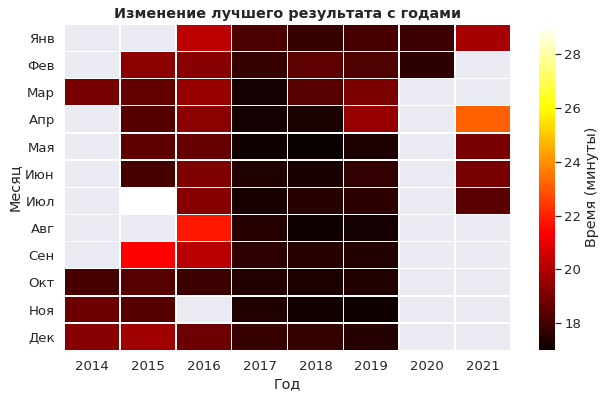

CPU times: user 556 ms, sys: 233 ms, total: 789 ms
Wall time: 1.03 s


In [22]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))

# pivot df into long form and aggregate by fastest time
rundata_long = df.pivot_table(index='Месяц', columns='Год', values='t_m', aggfunc=np.min, fill_value=np.nan)
# add rows of zeros for any months missed
for month in months:
    if month not in rundata_long.index.values :
        rundata_long.loc[month] = np.nan
# sort chronological
rundata_long = rundata_long.reindex(months)

sns.heatmap(rundata_long, linewidths=0.4, cmap='hot', cbar_kws={'label': 'Время (минуты)'}, ax=ax)
ax.set_title("Изменение лучшего результата с годами", fontweight='bold')
plt.show()

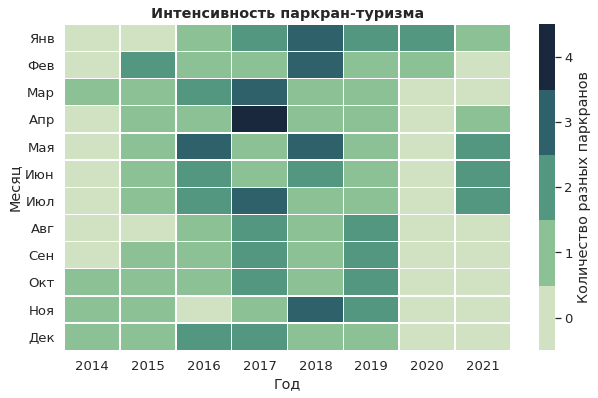

CPU times: user 516 ms, sys: 313 ms, total: 829 ms
Wall time: 973 ms


In [23]:
%%time
fig, ax = plt.subplots(figsize=(10, 6))
aggfun = lambda parkruns: len(np.unique(parkruns, return_counts = True)[1])
# pivot df into long form and aggregate by fastest time
rundata_long = df.pivot_table(index='Месяц', columns='Год', values='Паркран', aggfunc=aggfun, fill_value=0)
maxuniq = rundata_long.max().max()

# add rows of zeros for any months missed
for month in months:
    if month not in rundata_long.index.values :
        rundata_long.loc[month] = np.nan
# sort chronological
rundata_long = rundata_long.reindex(months)
cmap = sns.cubehelix_palette(rot=-.5, n_colors=maxuniq+1)

ticks=np.arange(0, maxuniq+1)
boundaries = np.arange(-0.5, maxuniq+1.5)

sns.heatmap(rundata_long, linewidths=0.4, cmap=cmap, cbar_kws={"ticks":ticks, 'label': 'Количество разных паркранов', "boundaries":boundaries}, ax=ax)
ax.set_title("Интенсивность паркран-туризма", fontweight='bold')
plt.show()

In [24]:
pd.to_datetime(df['Дата parkrun'], dayfirst=True).dt.year

0      2021
1      2021
2      2021
3      2021
4      2021
       ... 
188    2014
189    2014
190    2014
191    2014
192    2014
Name: Дата parkrun, Length: 193, dtype: int64

/media/vol1ura/winC/Users/Юрий/PycharmProjects/notebooks/jupyter/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/media/vol1ura/winC/Users/Юрий/PycharmProjects/notebooks/jupyter/lib/python3.8/site-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


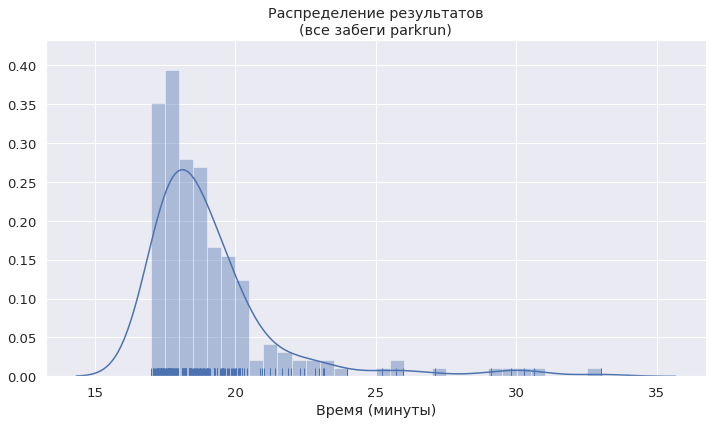

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(df['t_m'], bins=32, rug=True, ax=ax)
ax.set(ylabel='', xlabel='Время (минуты)', title='Распределение результатов\n(все забеги parkrun)')

# ax.invert_yaxis()
plt.tight_layout()

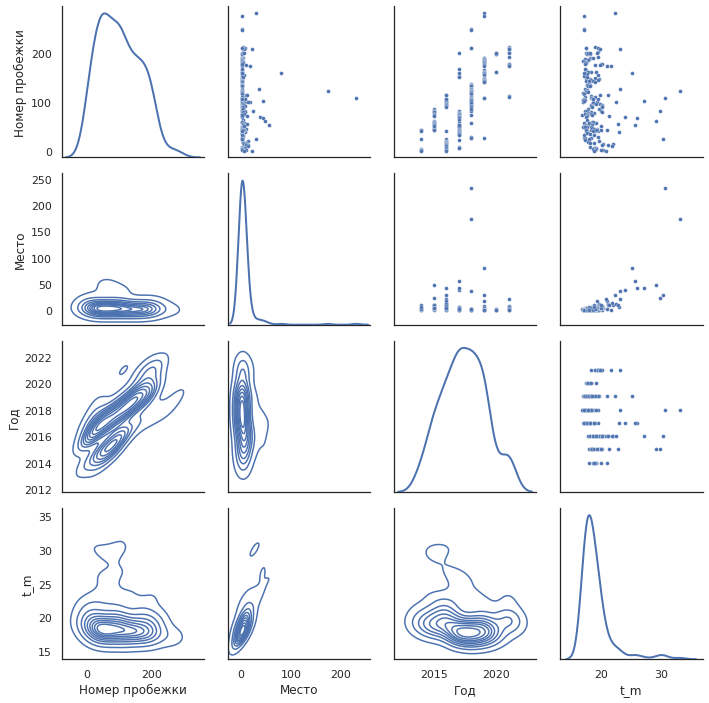

In [26]:
sns.set_theme(style="white")

g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

/media/vol1ura/winC/Users/Юрий/PycharmProjects/notebooks/jupyter/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/media/vol1ura/winC/Users/Юрий/PycharmProjects/notebooks/jupyter/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


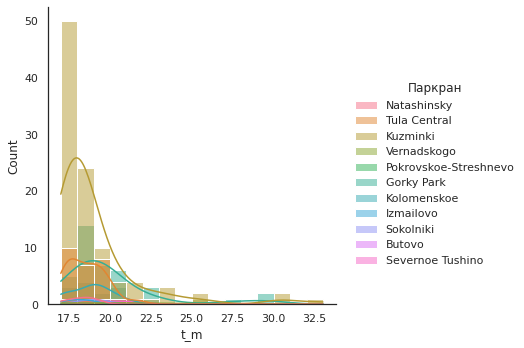

In [27]:
sns.displot(data=df, x='t_m', hue="Паркран", bins=16, kde=True)

<AxesSubplot:xlabel='t_m', ylabel='Паркран'>

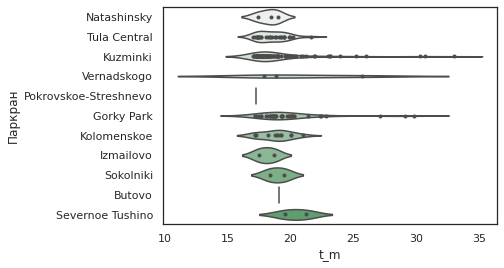

In [28]:
sns.violinplot(data=df, x='t_m', y='Паркран', palette="light:g", inner="points", orient="h")

In [29]:
pos_df = pd.crosstab(df['Паркран'], df['Место'], margins=True)
columns = [1,2,3,'All']
for i in columns:
    if i not in pos_df.columns:
        pos_df[i] = 0
pos_df = pos_df[columns].sort_values(by=columns, ascending=False)
total = pos_df.loc['All']
pos_df.drop('All', axis=0, inplace=True)
pos_df = pos_df.append(total)

In [30]:
separator = '-------------+-----+-----+-----+----'
rows = ['```', 'Паркран/Место|  1  |  2  |  3  | ∑ ', separator]
for row in pos_df.itertuples():
    rows.append(f'{row[0][:12]:<12} | {row[1]:3d} | {row[2]:3d} | {row[3]:3d} | {row[4]:3d}')
rows += [separator, rows.pop().replace('All  ', 'Итого'), '```']
print('\n'.join(rows))

```
Паркран/Место|  1  |  2  |  3  | ∑ 
-------------+-----+-----+-----+----
Kuzminki     |  36 |  27 |  10 | 101
Tula Central |  10 |  10 |   4 |  27
Gorky Park   |   4 |   6 |   4 |  39
Kolomenskoe  |   4 |   3 |   1 |  12
Natashinsky  |   1 |   0 |   1 |   3
Vernadskogo  |   1 |   0 |   1 |   3
Sokolniki    |   1 |   0 |   1 |   2
Severnoe Tus |   1 |   0 |   0 |   2
Butovo       |   1 |   0 |   0 |   1
Pokrovskoe-S |   1 |   0 |   0 |   1
Izmailovo    |   0 |   1 |   0 |   2
-------------+-----+-----+-----+----
Итого        |  60 |  47 |  22 | 193
```


In [31]:
pos_df

Место,1,2,3,All
Паркран,,,,
Kuzminki,36,27,10,101
Tula Central,10,10,4,27
Gorky Park,4,6,4,39
Kolomenskoe,4,3,1,12
Natashinsky,1,0,1,3
Vernadskogo,1,0,1,3
Sokolniki,1,0,1,2
Severnoe Tushino,1,0,0,2
Butovo,1,0,0,1


In [32]:
pd.crosstab(df['Паркран'], df['Место'], margins=True)

Место,1,2,3,4,5,6,7,8,9,10,...,30,36,38,43,48,56,81,174,232,All
Паркран,,,,,,,,,,,,,,,,,,,,,
Butovo,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Gorky Park,4,6,4,5,4,1,3,2,0,2,...,1,0,0,1,1,0,0,0,0,39
Izmailovo,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Kolomenskoe,4,3,1,0,2,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,12
Kuzminki,36,27,10,3,3,1,3,1,3,1,...,1,1,1,1,0,0,1,1,1,101
Natashinsky,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
Pokrovskoe-Streshnevo,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Severnoe Tushino,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Sokolniki,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


<Figure size 504x504 with 0 Axes>

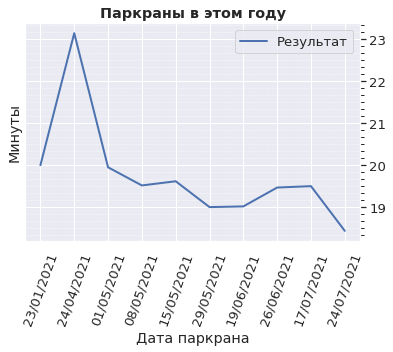

In [113]:
df_last = df.head(10)[::-1].reset_index(drop=True)
plt.figure(figsize=(7,7))
fig.patch.set_facecolor('#eeeeee')
ax = df_last.plot(x = 'Дата parkrun', y = 't_m', lw=2, label='Результат')
xlabels = df_last['Дата parkrun']
xl = xlabels.index
ax.set_xticks(xl)
ax.set_xticklabels(xlabels, rotation=70)
ax.minorticks_on()
ax.grid(which='minor', axis='y', lw=0.7, ls=':')
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1/6))
ax.yaxis.tick_right()
ax.xaxis.set_minor_locator(NullLocator())
plt.xlabel('Дата паркрана')
plt.ylabel('Минуты')
plt.title('Паркраны в этом году', fontweight='bold')
plt.show()